In [86]:
import sqlite3
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_recall_curve, 
    auc, 
    brier_score_loss, 
    classification_report
)
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import os

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [87]:
import subprocess
from pathlib import Path

# Make sure we can open the db file
try:
    root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip()
    os.chdir(root)
except Exception:
    while not (Path.cwd() / "data").exists() and Path.cwd() != Path.home():
        os.chdir("..")

print("Working directory:", Path.cwd())

Working directory: /Users/ecasto/cs230-project


Data loading

In [88]:
conn = sqlite3.connect("data/routes_scores.db")
df = pd.read_sql("SELECT * FROM routes;", conn)

# Basic route-level features
df["counties"] = df["counties"].fillna("")
df["county_count"] = df["counties"].str.count(",").fillna(0).astype(int) + 1

print("Label distribution:\n", df["impacting_delivery"].value_counts(normalize=True))
df[["counties", "county_count"]].head()

print("Dataset shape:", df.shape)
df.head()


Label distribution:
 impacting_delivery
0    0.76505
1    0.23495
Name: proportion, dtype: float64
Dataset shape: (20000, 5)


,route_id,counties,impact_score,impacting_delivery,county_count
0,1,"NORTH CENTRAL & SOUTHEAST SISKIYOU COUNTY,SAN ...",0.231843,0,4
1,2,"SANTA YNEZ MOUNTAINS EASTERN RANGE,SAN JOAQUIN...",0.228992,0,5
2,3,SANTA LUCIA MOUNTAINS AND LOS PADRES NATIONAL ...,0.227583,0,8
3,4,"HUMBOLDT,W CENTRAL S.J. VALLEY,SAN GORGONIO PA...",0.226957,0,6
4,5,"TRINITY,Carquinez Strait and Delta,ORANGE COUN...",0.262501,1,10


Common split function

In [89]:
def make_splits(df, feature_cols, target_col="impacting_delivery"):
    """
    Returns train/val/test splits given selected feature columns.
    Stratified by label.
    """
    df_clean = df.copy()
    
    # Basic missing handling
    for col in feature_cols:
        if df_clean[col].dtype == "O":  # object/categorical
            df_clean[col] = df_clean[col].fillna("Unknown")
        else:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    train, test = train_test_split(
        df_clean,
        test_size=0.15,
        random_state=42,
        stratify=df_clean[target_col]
    )
    train, val = train_test_split(
        train,
        test_size=0.1765,  # so final 70/15/15
        random_state=42,
        stratify=train[target_col]
    )
    
    X_train = train[feature_cols]
    y_train = train[target_col]
    X_val   = val[feature_cols]
    y_val   = val[target_col]
    X_test  = test[feature_cols]
    y_test  = test[target_col]
    
    print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
    print("Label distribution (train):")
    print(y_train.value_counts(normalize=True))
    
    return X_train, y_train, X_val, y_val, X_test, y_test


Preprocessing + tf.data helper

In [90]:
def build_preprocessor(numeric_features, categorical_features):
    numeric_transformer = Pipeline(steps=[
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )
    return preprocessor


In [91]:
def build_bow_preprocessor(text_feature, numeric_features):
    to_1d = FunctionTransformer(lambda x: x.squeeze(), validate=False)

    county_bow = Pipeline(steps=[
        ("to_1d", to_1d),
        ("vec", CountVectorizer(
            tokenizer=lambda s: [t.strip() for t in s.split(",") if t.strip()],
            lowercase=False,
            min_df=5,
        )),
    ])

    numeric_pipe = Pipeline(steps=[
        ("scaler", StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("county_bow", county_bow, [text_feature]),
            ("num", numeric_pipe, numeric_features),
        ]
    )

    return preprocessor


In [92]:
def preprocess_and_to_arrays(preprocessor, X_train, X_val, X_test):
    X_train_proc = preprocessor.fit_transform(X_train)
    X_val_proc   = preprocessor.transform(X_val)
    X_test_proc  = preprocessor.transform(X_test)

    # Many sklearn transformers return sparse matrices → convert to dense
    if hasattr(X_train_proc, "toarray"):
        X_train_proc = X_train_proc.toarray()
        X_val_proc   = X_val_proc.toarray()
        X_test_proc  = X_test_proc.toarray()

    print("Processed feature dim:", X_train_proc.shape[1])
    return X_train_proc, X_val_proc, X_test_proc


In [93]:
def make_tf_datasets(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train.values))
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val.values))
    test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test.values))
    
    train_ds = train_ds.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds  = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds


MLP model builder

In [94]:
def build_mlp(input_dim, l2_reg=1e-4, dropout_rate=0.3):
    model = Sequential([
        Dense(64, activation="relu", kernel_regularizer=l2(l2_reg), input_shape=(input_dim,)),
        Dense(32, activation="relu", kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="AUPRC", curve="PR")
        ]
    )
    
    model.summary()
    return model


Training + evaluation helper

In [95]:
def train_and_evaluate_mlp(
    X_train_proc, y_train,
    X_val_proc, y_val,
    X_test_proc, y_test,
    tag="with_score"
):
    # Build datasets
    train_ds, val_ds, test_ds = make_tf_datasets(
        X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test, batch_size=32
    )
    
    # Build model
    model = build_mlp(input_dim=X_train_proc.shape[1])
    
    # Callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Plot training curves
    os.makedirs("results", exist_ok=True)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.title(f"Loss Curves ({tag})")
    plt.savefig(f"results/mlp_loss_{tag}.png", dpi=150)
    plt.close()
    
    # Evaluate
    results = model.evaluate(test_ds, return_dict=True)
    print(f"\nTest metrics ({tag}):", results)
    
    # Choose threshold on validation set
    val_probs = model.predict(X_val_proc).ravel()
    prec_v, rec_v, thr_v = precision_recall_curve(y_val, val_probs)

    f1_v = (2 * prec_v * rec_v) / (prec_v + rec_v + 1e-12)
    best_idx = np.nanargmax(f1_v)
    best_thr = thr_v[best_idx] if best_idx < len(thr_v) else 0.5

    print(f"Best validation threshold (F1-optimal) = {best_thr:.3f}")

    # Predict probabilities on test set
    probs = model.predict(X_test_proc).ravel()

    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    auc_pr = auc(recall, precision)
    brier  = brier_score_loss(y_test, probs)

    print(f"AUPRC ({tag}):", auc_pr)
    print(f"Brier Score ({tag}):", brier)
    print("\nClassification Report (threshold from val):\n")
    y_pred_test = (probs >= best_thr).astype(int)
    print(classification_report(y_test, y_pred_test))

    # Save PR curve
    plt.plot(recall, precision)
    plt.title(f"Precision-Recall Curve ({tag}) AUC={auc_pr:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.savefig(f"results/pr_curve_mlp_{tag}.png", dpi=150)
    plt.close()
    
    # Save metrics
    metrics = results.copy()
    metrics["AUPRC_curve"] = auc_pr
    metrics["brier_score"] = brier
    metrics["best_threshold"] = best_thr
    pd.DataFrame([metrics]).to_csv(f"results/mlp_metrics_{tag}.csv", index=False)
    
    # Save model
    os.makedirs("models", exist_ok=True)
    model.save(f"models/mlp_{tag}.keras")
    
    return model, metrics


## Experiment 1 — With impact_score (Model A)

In [96]:
# Features for Model A (with impact_score)
numeric_features_A = ["impact_score"]
categorical_features_A = ["counties"]
feature_cols_A = numeric_features_A + categorical_features_A

X_train_A, y_train_A, X_val_A, y_val_A, X_test_A, y_test_A = make_splits(
    df, feature_cols_A, target_col="impacting_delivery"
)

preprocessor_A = build_preprocessor(numeric_features_A, categorical_features_A)
X_train_proc_A, X_val_proc_A, X_test_proc_A = preprocess_and_to_arrays(
    preprocessor_A, X_train_A, X_val_A, X_test_A
)


Train: (13999, 2) Val: (3001, 2) Test: (3000, 2)
Label distribution (train):
impacting_delivery
0    0.765055
1    0.234945
Name: proportion, dtype: float64
Processed feature dim: 14000


In [97]:
# Train & evaluate MLP (with impact_score)
mlp_with_score, metrics_with_score = train_and_evaluate_mlp(
    X_train_proc_A, y_train_A,
    X_val_proc_A, y_val_A,
    X_test_proc_A, y_test_A,
    tag="with_score"
)

/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 64)             │       896,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 898,177 (3.43 MB)

 Trainable params: 898,177 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUPRC: 0.9916 - loss: 0.1488 - precision: 0.9637 - recall: 0.9593 - val_AUPRC: 1.0000 - val_loss: 0.0390 - val_precision: 0.9738 - val_recall: 1.0000
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUPRC: 1.0000 - loss: 0.0206 - precision: 0.9979 - recall: 0.9994 - val_AUPRC: 1.0000 - val_loss: 0.0313 - val_precision: 0.9778 - val_recall: 1.0000
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUPRC: 1.0000 - loss: 0.0131 - precision: 1.0000 - recall: 1.0000 - val_AUPRC: 1.0000 - val_loss: 0.0276 - val_precision: 1.0000 - val_recall: 0.9943
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUPRC: 1.0000 - loss: 0.0116 - precision: 1.0000 - recall: 1.0000 - val_AUPRC: 1.0000 - val_loss: 0.0259 - val_precision: 0.9778 - val_recall: 1.0000
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUPRC: 1.0000 - loss: 0.0102 - precision: 1.0000 - recall: 1.0000 - val_AUPRC: 1.0000 - val_loss: 0.0231 - val_precision: 1.0000 -

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step


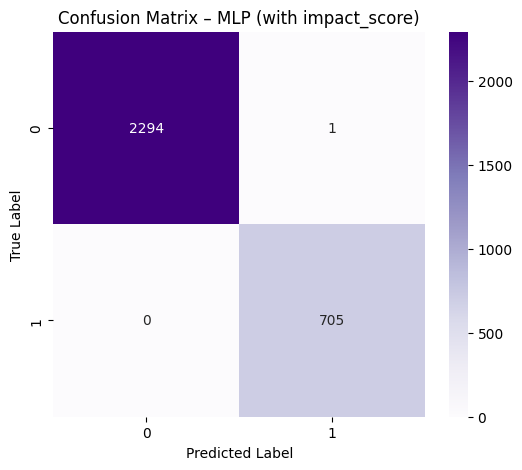

In [98]:
# Confusion Matrix for Model A
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

mlp_probs = mlp_with_score.predict(X_test_proc_A).ravel()
mlp_preds = (mlp_probs >= 0.5).astype(int)

cm_mlp = confusion_matrix(y_test_A, mlp_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix – MLP (with impact_score)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("results/cm_mlp_with_score.png", dpi=150)
plt.show()

## Experiment 2 — Without impact_score (Model B)

In [99]:
# Features for Model B (without impact_score)
numeric_features_B = []   # none
categorical_features_B = ["counties"]
feature_cols_B = categorical_features_B

X_train_B, y_train_B, X_val_B, y_val_B, X_test_B, y_test_B = make_splits(
    df, feature_cols_B, target_col="impacting_delivery"
)

preprocessor_B = build_preprocessor(numeric_features_B, categorical_features_B)
X_train_proc_B, X_val_proc_B, X_test_proc_B = preprocess_and_to_arrays(
    preprocessor_B, X_train_B, X_val_B, X_test_B
)


Train: (13999, 1) Val: (3001, 1) Test: (3000, 1)
Label distribution (train):
impacting_delivery
0    0.765055
1    0.234945
Name: proportion, dtype: float64
Processed feature dim: 13999


In [100]:
# Train & evaluate MLP (without impact_score)
mlp_no_score, metrics_no_score = train_and_evaluate_mlp(
    X_train_proc_B, y_train_B,
    X_val_proc_B, y_val_B,
    X_test_proc_B, y_test_B,
    tag="no_score"
)


/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 64)             │       896,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 898,113 (3.43 MB)

 Trainable params: 898,113 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUPRC: 0.2330 - loss: 0.5645 - precision: 0.1111 - recall: 6.0809e-04 - val_AUPRC: 0.2349 - val_loss: 0.5546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUPRC: 0.9422 - loss: 0.4195 - precision: 1.0000 - recall: 0.0140 - val_AUPRC: 0.2349 - val_loss: 0.5837 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUPRC: 1.0000 - loss: 0.1915 - precision: 1.0000 - recall: 0.9514 - val_AUPRC: 0.2349 - val_loss: 0.6102 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUPRC: 1.0000 - loss: 0.1427 - precision: 1.0000 - recall: 0.9948 - val_AUPRC: 0.2349 - val_loss: 0.6126 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUPRC: 1.0000 - loss: 0.1176 - precision: 1.0000 - recall: 0.9976 - val_AUPRC: 0.2349 - val_lo

/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step


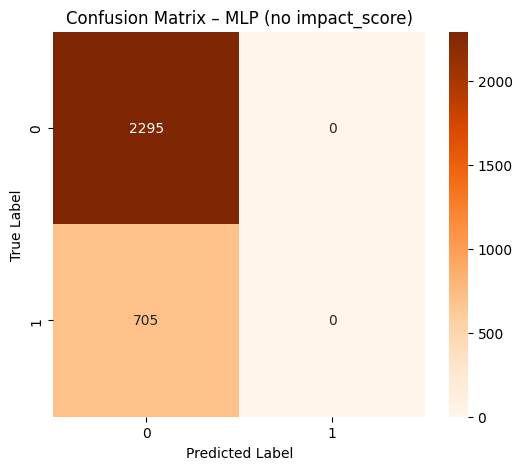

In [101]:
# Confusion Matrix for Model B
mlp_probs_no = mlp_no_score.predict(X_test_proc_B).ravel()
mlp_preds_no = (mlp_probs_no >= 0.5).astype(int)

cm_mlp_no = confusion_matrix(y_test_B, mlp_preds_no)

plt.figure(figsize=(6,5))
sns.heatmap(cm_mlp_no, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix – MLP (no impact_score)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("results/cm_mlp_no_score.png", dpi=150)
plt.show()

## Experiment 3 - bag of counties representation, without impact_score (Model C) 

In [112]:
text_feature_bow = "counties"
numeric_features_bow = ["county_count"]
feature_cols_bow = [text_feature_bow] + numeric_features_bow

X_train_bow, y_train_bow, X_val_bow, y_val_bow, X_test_bow, y_test_bow = make_splits(
    df,
    feature_cols_bow,
    target_col="impacting_delivery"
)

preprocessor_bow = build_bow_preprocessor(
    text_feature=text_feature_bow,
    numeric_features=numeric_features_bow,
)

X_train_proc_bow, X_val_proc_bow, X_test_proc_bow = preprocess_and_to_arrays(
    preprocessor_bow,
    X_train_bow,
    X_val_bow,
    X_test_bow,
)

Train: (13999, 2) Val: (3001, 2) Test: (3000, 2)
Label distribution (train):
impacting_delivery
0    0.765055
1    0.234945
Name: proportion, dtype: float64
Processed feature dim: 313


/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [113]:
mlp_bow, metrics_bow = train_and_evaluate_mlp(
    X_train_proc_bow, y_train_bow,
    X_val_proc_bow, y_val_bow,
    X_test_proc_bow, y_test_bow,
    tag="bow_counties"
)

/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 64)             │        20,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,209 (86.75 KB)

 Trainable params: 22,209 (86.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - AUPRC: 0.7574 - loss: 0.3582 - precision: 0.9064 - recall: 0.3740 - val_AUPRC: 0.9703 - val_loss: 0.1508 - val_precision: 0.9584 - val_recall: 0.7844
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - AUPRC: 0.9733 - loss: 0.1252 - precision: 0.9278 - recall: 0.8915 - val_AUPRC: 0.9852 - val_loss: 0.1024 - val_precision: 0.9513 - val_recall: 0.8865
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - AUPRC: 0.9901 - loss: 0.0855 - precision: 0.9496 - recall: 0.9346 - val_AUPRC: 0.9887 - val_loss: 0.0863 - val_precision: 0.9506 - val_recall: 0.9277
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - AUPRC: 0.9952 - loss: 0.0665 - precision: 0.9700 - recall: 0.9623 - val_AUPRC: 0.9851 - val_loss: 0.0988 - val_precision: 0.9225 - val_recall: 0.9461
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - AUPRC: 0.9971 - loss: 0.0565 - precision: 0.9747 - recall: 0.9711 - val_AUPRC: 0.9899 - val_loss: 0.0881 - val_precision

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


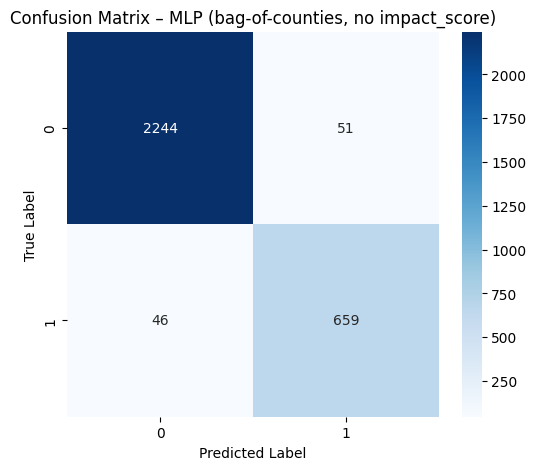

In [114]:
# Confusion Matrix for Model C
mlp_probs_bow = mlp_bow.predict(X_test_proc_bow).ravel()
mlp_preds_bow = (mlp_probs_bow >= 0.5).astype(int)

cm_mlp_bow = confusion_matrix(y_test_bow, mlp_preds_bow)

plt.figure(figsize=(6,5))
sns.heatmap(cm_mlp_bow, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – MLP (bag-of-counties, no impact_score)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("results/cm_mlp_bow.png", dpi=150)
plt.show()

Identify the routes the model got most wrong

In [116]:
results_df = X_test_bow.copy()
results_df["y_true"] = y_test_bow.values
results_df["y_prob"] = mlp_probs_bow
results_df["y_pred"] = (results_df["y_prob"] >= 0.5).astype(int)

# FALSE NEGATIVES
worst_fn = results_df[(results_df.y_true == 1) & (results_df.y_pred == 0)] \
    .sort_values("y_prob") \
    .head(10)

# FALSE POSITIVES
worst_fp = results_df[(results_df.y_true == 0) & (results_df.y_pred == 1)] \
    .sort_values("y_prob", ascending=False) \
    .head(10)

worst_fn.to_csv("results/mlp_worst_fn.csv", index=False)
worst_fp.to_csv("results/mlp_worst_fp.csv", index=False)

worst_fn, worst_fp

(                                                counties  county_count  \
 12725  COACHELLA VALLEY,NORTHEAST FOOTHILLS/SACRAMENT...             9   
 1406   SOLANO,MALIBU COAST,Kern County Mountains,SANT...             9   
 19147  Southern Sacramento Valley,SANTA CLARA,MOJAVE ...             5   
 7437   TEHACHAPI,SANTA CRUZ,SANTA MONICA MOUNTAINS RE...             7   
 17480  SANTA BARBARA COUNTY MOUNTAINS,KERN COUNTY DES...             9   
 1543   MARIPOSA - MADERA FOOTHILLS,CALAVERAS,SAN FRAN...             9   
 10513  CHUCKWALLA MOUNTAINS,JOSHUA TREE NP WEST,BUTTE...            10   
 17268  East Central San Joaquin Valley,SAN BERNARDINO...             4   
 17810  YOLO,NORTHEAST SISKIYOU AND NORTHWEST MODOC CO...             4   
 10258  NORTH COAST INTERIOR,SANTA BARBARA COUNTY SOUT...             7   
 
        y_true    y_prob  y_pred  
 12725       1  0.000013       0  
 1406        1  0.002468       0  
 19147       1  0.002789       0  
 7437        1  0.004286       0 

County-level misclassification

In [117]:
def explode_counties(df):
    df_copy = df.copy()
    df_copy["county_list"] = df_copy["counties"].str.split(",")
    return df_copy.explode("county_list")

expanded = explode_counties(results_df)

# Compute misclassification rates
expanded["is_wrong"] = (expanded.y_true != expanded.y_pred).astype(int)

county_error = expanded.groupby("county_list")["is_wrong"].mean().sort_values(ascending=False)

county_error.head(20)

county_list
BUTTE                              0.145161
SAN LUIS OBISPO COUNTY BEACHES     0.109589
YOLO                               0.106667
VENTURA COUNTY INLAND COAST        0.103448
KERN                               0.100000
NORTHERN MONTEREY BAY              0.092593
NORTH BAY INTERIOR MOUNTAINS       0.089552
STANISLAUS                         0.085714
Northern Sacramento Valley         0.085366
OWENS VALLEY                       0.083333
GLENN                              0.083333
MORONGO BASIN                      0.082192
LOS ANGELES COUNTY BEACHES         0.078431
Mt Shasta/Western Plumas County    0.078431
RIVERSIDE                          0.078125
SANTA CLARA                        0.076923
SANTA CRUZ                         0.076923
MENDOCINO COAST                    0.075472
TRINITY                            0.074627
CHUCKWALLA MOUNTAINS               0.072727
Name: is_wrong, dtype: float64

In [118]:
plt.hist(results_df[results_df.y_true == 1]["y_prob"], bins=20)
plt.title("Probability Distribution for True Positive Routes")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.savefig("results/positive_prob_distribution.png")
plt.close()

## Comparison table

In [111]:
comparison = pd.DataFrame([
    {"model": "MLP_with_score", "AUPRC": metrics_with_score["AUPRC_curve"], "brier": metrics_with_score["brier_score"]},
    {"model": "MLP_no_score",   "AUPRC": metrics_no_score["AUPRC_curve"],   "brier": metrics_no_score["brier_score"]},
    {"model": "MLP_no_score_bow_counties", "AUPRC": metrics_bow["AUPRC_curve"], "brier":  metrics_bow["brier_score"],
    },
])

comparison


,model,AUPRC,brier
0,MLP_with_score,1.000000,0.001062
1,MLP_no_score,0.617500,0.180131
2,MLP_no_score_bow_counties,0.987562,0.022139


In [108]:
#Save results for error analysis
np.save("results/mlp_with_score_probs.npy", mlp_probs)
np.save("results/mlp_with_score_y_test.npy", y_test_A.values)

np.save("results/mlp_no_score_probs.npy", mlp_probs_no)
np.save("results/mlp_no_score_y_test.npy", y_test_B.values)

np.save("results/mlp_bow_probs.npy", mlp_probs_bow)
np.save("results/mlp_bow_y_test.npy", y_test_bow.values)


## Hyperparameter testing

Dropout:

In [119]:
from tensorflow.keras.callbacks import EarlyStopping

#build datasets
Xtr = X_train_proc_bow
Xv  = X_val_proc_bow
Xt  = X_test_proc_bow
ytr = y_train_bow
yv  = y_val_bow
yt  = y_test_bow

train_ds, val_ds, test_ds = make_tf_datasets(
    Xtr, ytr, Xv, yv, Xt, yt, batch_size=32
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

dropouts = [0.1, 0.3, 0.5]
dropout_results = []

for d in dropouts:    
    model = build_mlp(input_dim=Xtr.shape[1], dropout_rate=d)
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        callbacks=[early_stop],
        verbose=0
    )

    best_val_loss = min(history.history["val_loss"])
    
    dropout_results.append({"dropout": d, "val_loss": best_val_loss})

pd.DataFrame(dropout_results)

/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 64)             │        20,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,209 (86.75 KB)

 Trainable params: 22,209 (86.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 64)             │        20,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,209 (86.75 KB)

 Trainable params: 22,209 (86.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_51 (Dense)                │ (None, 64)             │        20,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,209 (86.75 KB)

 Trainable params: 22,209 (86.75 KB)

 Non-trainable params: 0 (0.00 B)

,dropout,val_loss
0,0.1,0.085716
1,0.3,0.092350
2,0.5,0.094440


Learning Rate:

In [120]:
learning_rates = [1e-4, 3e-4, 1e-3]
lr_results = []

for lr in learning_rates:
    # Build new model with this LR
    model = Sequential([
        Dense(64, activation="relu", kernel_regularizer=l2(1e-4), input_shape=(Xtr.shape[1],)),
        Dense(32, activation="relu", kernel_regularizer=l2(1e-4)),
        Dropout(0.1),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="AUPRC", curve="PR")
        ]
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        callbacks=[early_stop],
        verbose=0
    )

    best_val_loss = min(history.history["val_loss"])
    
    lr_results.append({"learning_rate": lr, "val_loss": best_val_loss})

pd.DataFrame(lr_results)


/Users/ecasto/cs230-project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


,learning_rate,val_loss
0,0.0001,0.242596
1,0.0003,0.088974
2,0.0010,0.087545
